In [1]:
%%time

## Import Packages 

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.utils import resample
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Display Runtime for Each Relevant Cell



CPU times: user 1.42 s, sys: 409 ms, total: 1.83 s
Wall time: 1.34 s


In [2]:
## I inexplicably needed to Change My Working Directory

import os

os.chdir('/Users/Amechi/Documents/Python Files')


In [3]:
## Import Files

df = pd.read_csv('weatherAUS.csv')


In [4]:
### Data Cleaning

## Clearing Columns With Large Amount of NA

df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1)
df = df.dropna()

## Making 'RainToday' and 'RainTomorrow' binary

df['RainToday'] = [1 if b=='Yes' else 0 for b in df.RainToday]
df['RainTomorrow'] = [1 if b=='Yes' else 0 for b in df.RainTomorrow]


# Comparing the Effectiveness of the Decision Tree and Random Forest in Predicting Rainfall in Australia

Random forest is one of the most common models in data science due to its high performance and ease of use. The decision tree is a more simplified version of the random forest that is more prone to overfitting and high variances. To gain more insight into the model types, I compared the abilities of both - across three means of feature selection - to predict rainfall in Australia using data from several weather stations. 

The dataset consists of 142193 observations of the variables related to the time of the observations, location of the observation, and elements of the weather present during the observation. The variable that the models were made to predict is 'RainTomorrow'. The other variables were used as predictors.

In [5]:
df.head(7)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.400,22.900,0.600,W,44.000,W,WNW,20.000,24.000,71.000,22.000,1007.700,1007.100,16.900,21.800,0,0.000,0
1,2008-12-02,Albury,7.400,25.100,0.000,WNW,44.000,NNW,WSW,4.000,22.000,44.000,25.000,1010.600,1007.800,17.200,24.300,0,0.000,0
2,2008-12-03,Albury,12.900,25.700,0.000,WSW,46.000,W,WSW,19.000,26.000,38.000,30.000,1007.600,1008.700,21.000,23.200,0,0.000,0
3,2008-12-04,Albury,9.200,28.000,0.000,NE,24.000,SE,E,11.000,9.000,45.000,16.000,1017.600,1012.800,18.100,26.500,0,1.000,0
4,2008-12-05,Albury,17.500,32.300,1.000,W,41.000,ENE,NW,7.000,20.000,82.000,33.000,1010.800,1006.000,17.800,29.700,0,0.200,0
5,2008-12-06,Albury,14.600,29.700,0.200,WNW,56.000,W,W,19.000,24.000,55.000,23.000,1009.200,1005.400,20.600,28.900,0,0.000,0
6,2008-12-07,Albury,14.300,25.000,0.000,W,50.000,SW,W,20.000,24.000,49.000,19.000,1009.600,1008.200,18.100,24.600,0,0.000,0


## Data Exploration

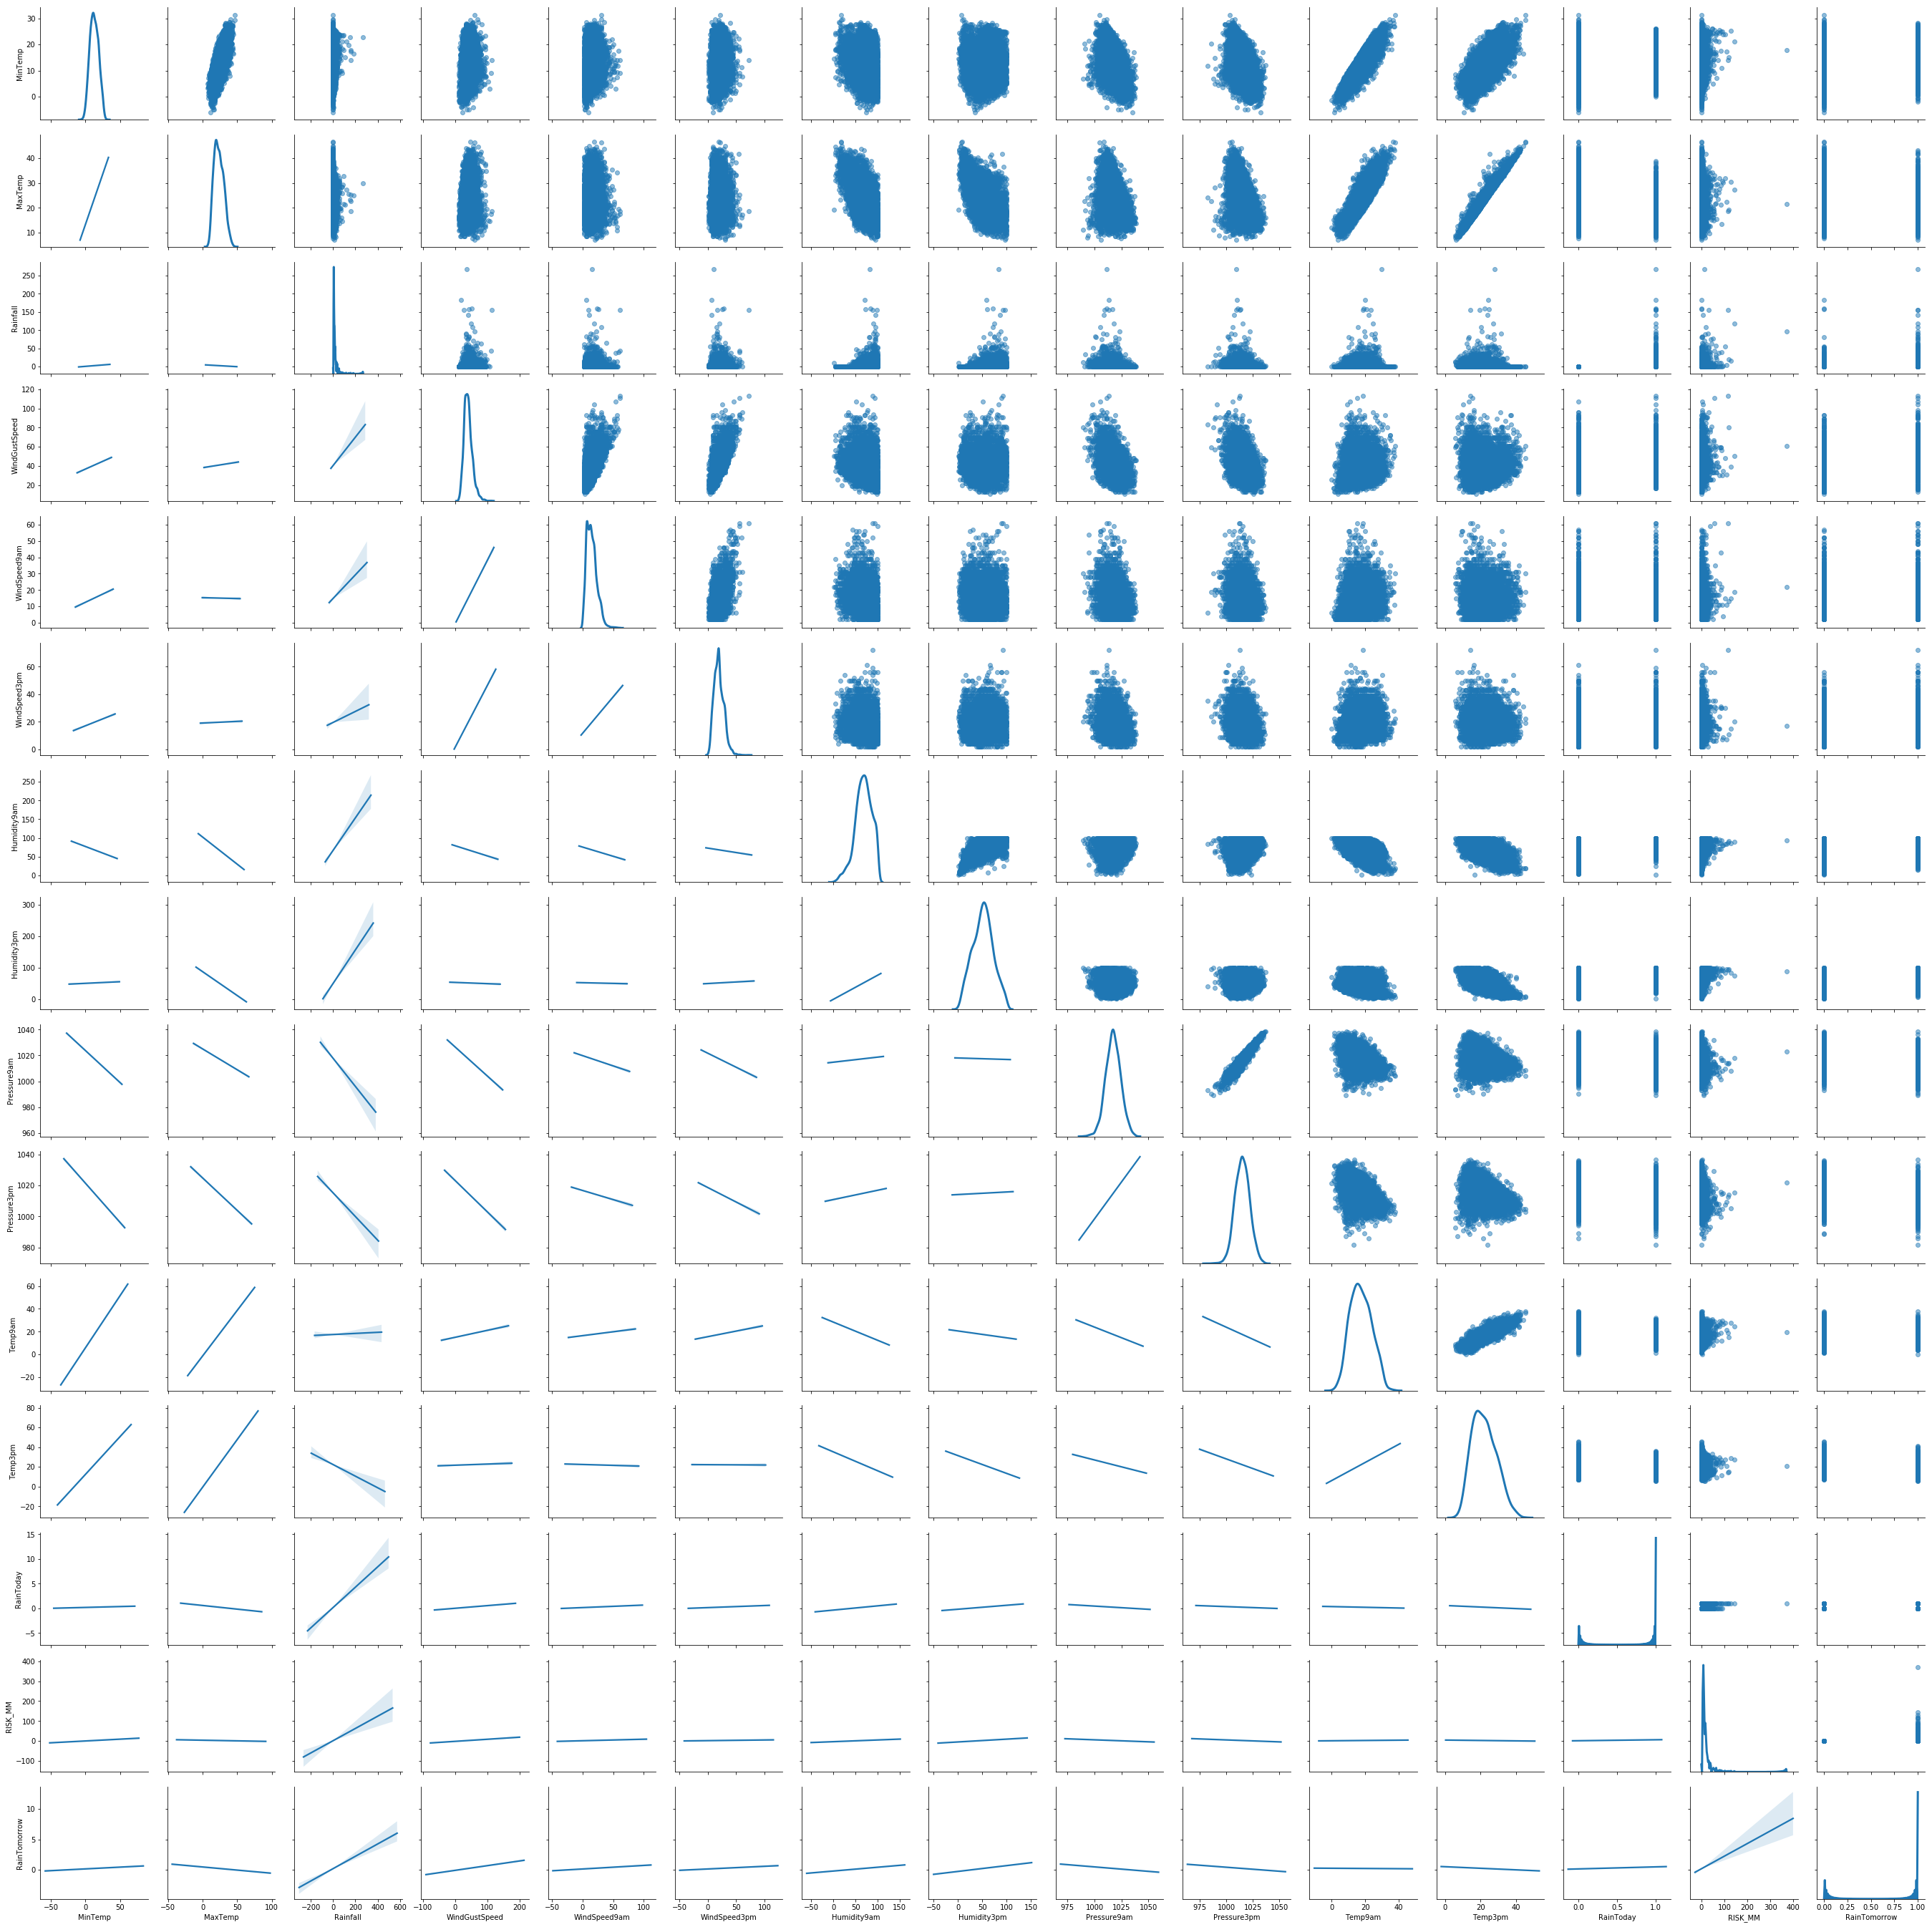

In [6]:
### Creating Scatterplot Matrix with Sample of DataFrame

## Store samples of DataFrame For Visualization

df_sample = df.sample(frac=.05)

## Declare Pairgrid
g = sns.PairGrid(df_sample.dropna(), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.5)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

A small sample of the data was used for the scatterplot matrix to reduce runtimes. Linear relationships exist within the wind, temperature and pressure variables. Many of the continuous variables show signs of binomial distribution. 

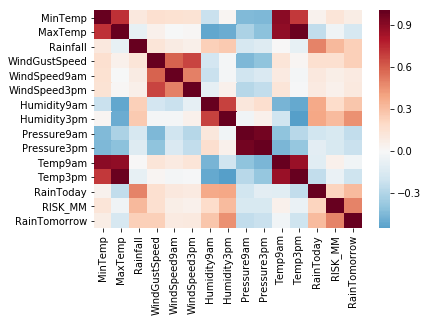

In [7]:
## Visualizing the Correlatedness of the variables

sns.heatmap(df.corr(), cmap='RdBu_r', center=0 )
plt.show()

There's moderate to strong correlatedness within the wind, temperature, humidity, and pressure variables. There's negative correlatedness between: the temperature and the pressure variables; and the temperature and humidity variables.

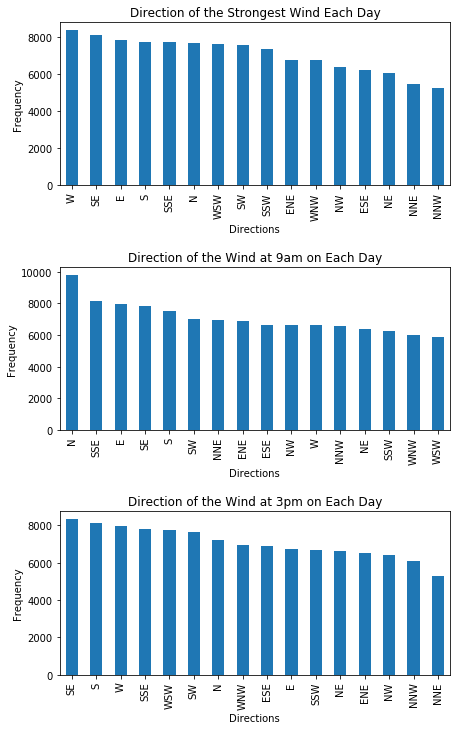

In [8]:
## Barplot of Wind Directions

fig = plt.figure(figsize=(7, 12))
fig.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
ax = df['WindGustDir'].value_counts().plot(kind='bar',
                                    
                                    title="Direction of the Strongest Wind Each Day")
ax.set_xlabel("Directions")
ax.set_ylabel("Frequency")

plt.subplot(3, 1, 2)
ax = df['WindDir9am'].value_counts().plot(kind='bar',
                                    
                                    title="Direction of the Wind at 9am on Each Day")
ax.set_xlabel("Directions")
ax.set_ylabel("Frequency")

plt.subplot(3, 1, 3)

ax = df['WindDir3pm'].value_counts().plot(kind='bar',
                                    
                                    title="Direction of the Wind at 3pm on Each Day")
ax.set_xlabel("Directions")
ax.set_ylabel("Frequency")
plt.show()

The number of places that where south and westward winds were recorded was larger at 3pm than 9am.

In [9]:
print(df['RainTomorrow'].value_counts())

print("\nFraction of \'No\' observations: " + str(df['RainTomorrow'].value_counts().iloc[0] / (df['RainTomorrow'].value_counts().iloc[0] + df['RainTomorrow'].value_counts().iloc[1])))
print("\nFraction of \'Yes\' observations: " + str(df['RainTomorrow'].value_counts().iloc[1] / (df['RainTomorrow'].value_counts().iloc[0] + df['RainTomorrow'].value_counts().iloc[1])))

0    87906
1    25019
Name: RainTomorrow, dtype: int64

Fraction of 'No' observations: 0.7784458711534205

Fraction of 'Yes' observations: 0.2215541288465796


The 'No' class made the majority of 'RainTomorrow' Observations. The strong class imbalance will need to be remedied prior to modeling.

In [10]:
## Descriptive Statistics

df.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
count,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000,112925.000
mean,12.665,23.656,2.378,40.787,15.179,19.501,67.404,50.669,1017.426,1015.049,17.462,22.127,0.225,2.326,0.222
std,6.254,6.983,8.603,13.322,8.344,8.580,18.912,20.769,7.033,6.958,6.355,6.837,0.417,8.517,0.415
min,-8.200,2.600,0.000,7.000,2.000,2.000,0.000,0.000,980.500,977.100,-3.100,1.700,0.000,0.000,0.000
25%,8.100,18.300,0.000,31.000,9.000,13.000,56.000,36.000,1012.800,1010.300,12.700,16.900,0.000,0.000,0.000
50%,12.400,23.100,0.000,39.000,13.000,19.000,68.000,51.000,1017.400,1015.000,17.100,21.600,0.000,0.000,0.000
75%,17.200,28.700,0.800,48.000,20.000,24.000,81.000,65.000,1022.100,1019.700,22.000,26.900,0.000,0.600,0.000
max,33.900,48.100,367.600,135.000,87.000,87.000,100.000,100.000,1041.000,1039.600,40.200,46.700,1.000,371.000,1.000


Strong outliers existed in the the rain-related and windspeed-related variables.

## Preparing the Data for Modeling

In [11]:
## Class Balancing by Upsampling Minority Class

# Separate majority and minority classes
df_majority = df[df.RainTomorrow==0]
df_minority = df[df.RainTomorrow==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=87906,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


## Drop Date

df_upsampled_date_dropped = df_upsampled.drop(['Date'], axis=1)

## Get Dummies

df_model = pd.get_dummies(df_upsampled_date_dropped)



In [12]:
df_model['RainTomorrow'].value_counts()

1    87906
0    87906
Name: RainTomorrow, dtype: int64

I considered making date a continuous, numerical datatype and adding it to the models. However, if the classifier can't predict outside of the range of the training data then it's possible that the 'Date' variable may inhibit prediction of rainfall on future dates. With this in mind, I elected to remove the 'Date' predictor from the model.

I suspect that removing outliers may not be necessary for decision trees and random forest, so I refrained from imputing those values.

## Decision Tree Models

I ran decision trees using three different sets of predictors: the all of original features of the DataFrame,  predictors based on the function 'selectkbest', and components from PCA. I used results from these models to create and tune a final decision tree model to be compared to a random forest model.

In [13]:
x = df_model.drop(['RainTomorrow'], axis=1)
y = df_model['RainTomorrow']

### Using the Original Features of the Dataset

In [14]:
%%time

## Model

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=25,
)

model_d1=decision_tree.fit(x, y)



CPU times: user 343 ms, sys: 93.2 ms, total: 436 ms
Wall time: 435 ms


In [15]:

## Cross Validation

cv = cross_val_score(model_d1, x, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

model_d1_pred = model_d1.predict(x)
print(str(confusion_matrix(y, model_d1_pred))+'\n')

## classification_report

print(classification_report(y, model_d1_pred))


[0.81327494 0.8600273  0.72016835 0.86093732 0.85433967 0.89830508
 0.93594994 0.93333333 0.77519909 0.84283276]

0.8494367798331343

[[84601  3305]
 [ 4175 83731]]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     87906
           1       0.96      0.95      0.96     87906

   micro avg       0.96      0.96      0.96    175812
   macro avg       0.96      0.96      0.96    175812
weighted avg       0.96      0.96      0.96    175812



### Using Select K Best

In [16]:
## SelectKBest for feature selection

selector = SelectKBest(f_classif, k=25)
k_predictors = selector.fit_transform(x,y)

In [17]:
%%time

## Model

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=25,
)

model_d2=decision_tree.fit(k_predictors, y)



CPU times: user 101 ms, sys: 10.2 ms, total: 111 ms
Wall time: 110 ms


In [18]:

## Cross Validation

cv = cross_val_score(model_d2, k_predictors, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

model_d2_pred = model_d2.predict(k_predictors)
print(str(confusion_matrix(y, model_d2_pred))+'\n')

## classification_report

print(classification_report(y, model_d2_pred))


[1.         1.         0.99778182 0.99306109 1.         0.94329428
 0.99988623 1.         0.99749716 0.97684869]

0.9908369267669425

[[87906     0]
 [    0 87906]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87906
           1       1.00      1.00      1.00     87906

   micro avg       1.00      1.00      1.00    175812
   macro avg       1.00      1.00      1.00    175812
weighted avg       1.00      1.00      1.00    175812



k = 25 is the highest number of features that could still produce a perfect confusion matrix. Lower values of k produced higher accuracy scores but I chose to use k = 25 to retain as much information as possible and avoid overfitting.

### Using Principal Component Analysis

In [19]:
## PCA

# Normalize the data for PCA

X = StandardScaler().fit_transform(x)

# Perform PCA

sklearn_pca = PCA(n_components=25)
Y_sklearn = sklearn_pca.fit_transform(X)

# Turn PCA Result into Dataframe

pca_components = pd.DataFrame(data=Y_sklearn)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

print(
    '\nThe percentage of total variance in the dataset explained by all',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum()
)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.04708045 0.03414097 0.02780421 0.02201791 0.02017808 0.01917733
 0.01719976 0.0157867  0.01554749 0.0135148  0.01329416 0.01248327
 0.01225314 0.01184668 0.01134282 0.01110772 0.01101999 0.01075535
 0.01062423 0.01049943 0.01032301 0.01028884 0.01019684 0.01003598
 0.0100084 ]

The percentage of total variance in the dataset explained by all component from Sklearn PCA.
 0.39852756740010037


In [20]:
%%time

## Model

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=25,
)

model_d3=decision_tree.fit(pca_components, y)



CPU times: user 2.29 s, sys: 9.94 ms, total: 2.3 s
Wall time: 2.31 s


In [21]:

## Cross Validation

cv = cross_val_score(model_d3, pca_components, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

model_d3_pred = model_d3.predict(pca_components)
print(str(confusion_matrix(y, model_d3_pred))+'\n')

## classification_report

print(classification_report(y, model_d3_pred))



[0.83329542 0.75969742 0.77215334 0.80371971 0.83414856 0.76487317
 0.77332196 0.89613197 0.83777019 0.78384528]

0.8058957009372886

[[86553  1353]
 [  321 87585]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     87906
           1       0.98      1.00      0.99     87906

   micro avg       0.99      0.99      0.99    175812
   macro avg       0.99      0.99      0.99    175812
weighted avg       0.99      0.99      0.99    175812



### Selecting and Tuning Most Desirable Decision tree

In [22]:
%%time

## Gridsearch CV

# define decision tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy'
    
)

# Establish parameters
parameters = { 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy'],
              'max_depth': [2, 3, 5, 10, 25, 30], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(decision_tree, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(k_predictors,  y)

# Set the clf to the best combination of parameters
new_dt = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
new_dt.fit(k_predictors,  y)



/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 1min 1s, sys: 12 s, total: 1min 13s
Wall time: 1min 13s


In [23]:
## Cross Validation

cv = cross_val_score(new_dt, k_predictors, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

new_dt_pred = new_dt.predict(k_predictors)
print(str(confusion_matrix(y, new_dt_pred))+'\n')

## classification_report

print(classification_report(y, new_dt_pred))


[0.94187237 0.67057218 1.         0.89716756 0.77721533 0.77039017
 0.93122867 0.98043231 1.         0.91228669]

0.8881165276722536

[[78602  9304]
 [ 5859 82047]]

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     87906
           1       0.90      0.93      0.92     87906

   micro avg       0.91      0.91      0.91    175812
   macro avg       0.91      0.91      0.91    175812
weighted avg       0.91      0.91      0.91    175812



In [24]:
## Accuracy score

print(accuracy_score(y, new_dt_pred))

0.913754464996701


## Random Forest Models

I ran random forest using three different sets of predictors: the all of original features of the DataFrame,  predictors based on the function 'selectkbest', and components from PCA. I used results from these models to create and tune a final decision tree model to be compared to a random forest model.

### Using the Original Features of the Dataset

In [25]:
%%time

## Model

rfc = ensemble.RandomForestClassifier()

model_r1=rfc.fit(x, y)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1.8 s, sys: 109 ms, total: 1.91 s
Wall time: 1.91 s


In [26]:
## Cross Validation

cv = cross_val_score(model_r1, x, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

model_r1_pred = model_r1.predict(x)
print(str(confusion_matrix(y, model_r1_pred))+'\n')

## classification_report

print(classification_report(y, model_r1_pred))



[0.97844386 0.94773063 0.80656353 0.99089978 0.99647367 0.99459675
 0.93725825 0.99903299 0.99926052 0.99533561]

0.964559559633398

[[87906     0]
 [    0 87906]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87906
           1       1.00      1.00      1.00     87906

   micro avg       1.00      1.00      1.00    175812
   macro avg       1.00      1.00      1.00    175812
weighted avg       1.00      1.00      1.00    175812



### Using Select K Means

In [27]:
%%time

## Model with Select K Means

rfc = ensemble.RandomForestClassifier()

model_r2=rfc.fit(k_predictors, y)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1.16 s, sys: 25.9 ms, total: 1.19 s
Wall time: 1.19 s


In [28]:
## Cross Validation

cv = cross_val_score(model_r2, k_predictors, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

model_r2_pred = model_r2.predict(k_predictors)
print(str(confusion_matrix(y, model_r2_pred))+'\n')

## classification_report

print(classification_report(y, model_r2_pred))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

1.0

[[87906     0]
 [    0 87906]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87906
           1       1.00      1.00      1.00     87906

   micro avg       1.00      1.00      1.00    175812
   macro avg       1.00      1.00      1.00    175812
weighted avg       1.00      1.00      1.00    175812



### Using Principal Component Analysis

In [29]:
%%time

## Model with PCA

rfc = ensemble.RandomForestClassifier()

model_r3=rfc.fit(pca_components, y)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 10.3 s, sys: 32.1 ms, total: 10.4 s
Wall time: 10.4 s


In [30]:
## Cross Validation

cv = cross_val_score(model_r3, pca_components, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

model_r3_pred = model_r3.predict(pca_components)
print(str(confusion_matrix(y, model_r3_pred))+'\n')

## classification_report

print(classification_report(y, model_r3_pred))



[0.8811853  0.78102605 0.80758731 0.86918439 0.87578205 0.80246843
 0.75346985 0.93441411 0.89209329 0.81097838]

0.8408189165695756

[[87783   123]
 [  124 87782]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87906
           1       1.00      1.00      1.00     87906

   micro avg       1.00      1.00      1.00    175812
   macro avg       1.00      1.00      1.00    175812
weighted avg       1.00      1.00      1.00    175812



### Selecting and Tuning Most Desirable Random Forest

In [34]:
%%time

## Gridsearch CV

# define decision tree
rfc = ensemble.RandomForestClassifier()

# Establish parameters
parameters = { 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy'],
              'max_depth': [2, 3, 5, 10, 25, 30], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(k_predictors,  y)

# Set the clf to the best combination of parameters
new_rf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
new_rf.fit(k_predictors,  y)



/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

CPU times: user 5min 5s, sys: 15 s, total: 5min 20s
Wall time: 5min 21s


In [35]:
## Cross Validation

cv = cross_val_score(new_rf, k_predictors, y, cv=10)
print(cv)
print("\n"+str(cv.mean())+"\n")

## Confusion Matrix

new_rf_pred = new_rf.predict(k_predictors)
print(str(confusion_matrix(y, new_rf_pred))+'\n')

## classification_report

print(classification_report(y, new_rf_pred))


[1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99994312]

0.9999943117178611

[[87906     0]
 [    0 87906]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87906
           1       1.00      1.00      1.00     87906

   micro avg       1.00      1.00      1.00    175812
   macro avg       1.00      1.00      1.00    175812
weighted avg       1.00      1.00      1.00    175812



In [36]:
## Accuracy score


print(accuracy_score(y, new_rf_pred))

1.0


## Analyzing the Compared Effectiveness of the Final Decision Tree and Random Forest Models

The final decision tree had a lower accuracy than the random forest. The random forest model had a very high accuracy with some signs of overfitting. Ultimately, the random forest model made for the better model to predict the possibility of rain in Australia, the next day. The high comparative precision of the random forest in this study makes it clear why the model's use has become so widespread in data science.